#### CSC 180  Intelligent Systems (Fall 2022)

#### Dr. Haiquan Chen, Dept of Computer Scicence

#### California State University, Sacramento



## Lab 11  Multi-output Regression and Auto-encoder 


## Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


# Multi-Output Regression

Unlike most models, neural networks can provide multiple regression outputs.  This allows a neural network to generate multiple outputs for the same input.    


### The following program uses a multi-output regression to predict both [sin](https://en.wikipedia.org/wiki/Trigonometric_functions#Sine.2C_cosine_and_tangent) and [cos](https://en.wikipedia.org/wiki/Trigonometric_functions#Sine.2C_cosine_and_tangent) from the same input data.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics

x = np.sort((360 * np.random.rand(1000, 1)), axis=0)
y = np.array([np.pi * np.sin(x*(np.pi/180.0)).ravel(), np.pi * np.cos(x*(np.pi/180.0)).ravel()]).T


In [2]:
x

array([[  0.76741007],
       [  1.20739101],
       [  1.26095589],
       [  1.95544325],
       [  2.11602737],
       [  2.32218691],
       [  2.79272069],
       [  2.88119717],
       [  2.92739995],
       [  3.09465913],
       [  3.24189245],
       [  3.79349791],
       [  3.83791635],
       [  3.85995538],
       [  4.41416281],
       [  4.49907736],
       [  4.6258348 ],
       [  5.15829531],
       [  5.49057741],
       [  5.52451371],
       [  5.74834633],
       [  6.64627623],
       [  6.95896943],
       [  7.01130322],
       [  7.15840642],
       [  7.41783892],
       [  8.8064663 ],
       [  9.93088256],
       [  9.9527325 ],
       [ 10.02590637],
       [ 10.41755706],
       [ 10.63030855],
       [ 10.8152463 ],
       [ 10.93999845],
       [ 11.0460664 ],
       [ 11.57839974],
       [ 11.87776076],
       [ 11.96355149],
       [ 12.02957403],
       [ 12.3822962 ],
       [ 12.52550704],
       [ 12.97942037],
       [ 13.19410645],
       [ 13

In [3]:
y

array([[ 0.04207671,  3.14131087],
       [ 0.06619772,  3.14089514],
       [ 0.06913406,  3.14083188],
       ...,
       [-0.09783805,  3.14006881],
       [-0.06148128,  3.140991  ],
       [-0.02900512,  3.14145875]])

In [4]:
model = Sequential()

model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))

model.add(Dense(2)) # Two output neurons

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x,y,verbose=0,batch_size=32,epochs=100)

model.summary()

# Fit regression DNN model.
pred = model.predict(x)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 6,577
Trainable params: 6,577
Non-trainable params: 0
_________________________________________________________________


In [5]:
score = np.sqrt(metrics.mean_squared_error(pred, y))

print("Score (RMSE): {}".format(score))
print()
print()

print("Predicted:")
print(np.array(pred[0:5]))

print("Expected:")
print(np.array(y[0:5]))

Score (RMSE): 0.48017674058553966


Predicted:
[[ 4.0448204e-02  3.0171065e+00]
 [ 1.9946113e-02  3.0377409e+00]
 [ 1.7449871e-02  3.0402532e+00]
 [-2.6774257e-03  3.0690594e+00]
 [-9.3712658e-03  3.0755870e+00]]
Expected:
[[0.04207671 3.14131087]
 [0.06619772 3.14089514]
 [0.06913406 3.14083188]
 [0.10719836 3.13976319]
 [0.11599781 3.13945042]]


# Simple Auto Encoder

### An auto encoder is a neural network that has the same number of input neurons as output neurons.  
The hidden layers of the neural network will have fewer neurons than the input/output neurons.  Because there are fewer neurons, the auto-encoder must learn to encode the input to the fewer hidden neurons.  The predictors (x) and output (y) are exactly the same in an auto encoder.  Because of this, auto encoders are said to be unsupervised.  

![Simple Auto Encoder](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_13_auto_encode.png "Simple Auto Encoder")

### The following program demonstrates an auto encoder that learns to encode an image.  

# Reading Images in Python using Pillow

https://pillow.readthedocs.io/en/stable/index.html


#### The following code uses Pillow to load and display an image in RGB color model.

[[[ 55  59   0]
  [ 73  77  18]
  [ 54  60   0]
  ...
  [ 72  78   4]
  [ 75  81   9]
  [ 55  61   0]]

 [[102 104  41]
  [ 53  58   0]
  [ 66  71   4]
  ...
  [ 63  70   0]
  [ 82  88  16]
  [ 96 102  32]]

 [[129 130  62]
  [ 75  76   6]
  [ 83  87  13]
  ...
  [ 95 102  24]
  [123 129  55]
  [ 62  68   0]]

 ...

 [[ 71  53  31]
  [ 88  70  48]
  [ 55  38  18]
  ...
  [ 84  81  28]
  [165 162 109]
  [155 152 101]]

 [[100  79  62]
  [ 89  68  51]
  [ 95  76  59]
  ...
  [124 119  64]
  [134 129  74]
  [153 147  95]]

 [[154 131 117]
  [142 120 106]
  [150 128 115]
  ...
  [115 110  54]
  [106 101  45]
  [112 107  51]]]
shape:  (682, 1024, 3)


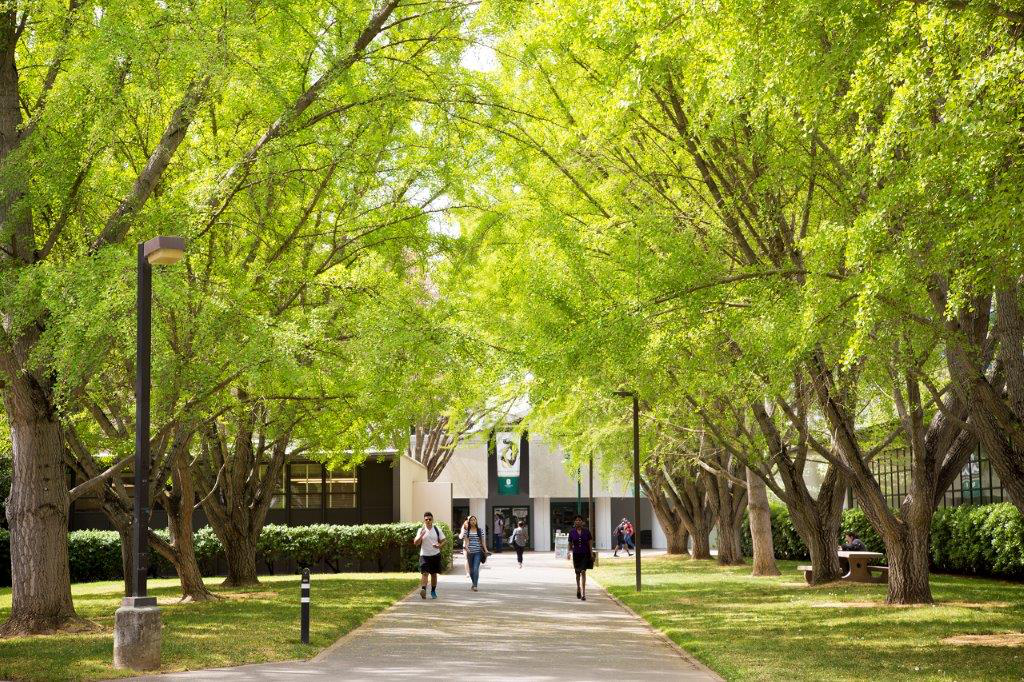

In [3]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

%matplotlib inline

url = "https://www.csus.edu/news/files/1_Campus_Spring_Flowers_Students_FB_20150330_0011.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

print(np.asarray(img))
print('shape: ', np.asarray(img).shape)

img

# Creating Images at pixel level


Pillow can also be used to create an image from a 3D numpy cube.  The rows and columns specify the pixels.  The depth, of 3, specifies red, green and blue.  Here a simple image is created.

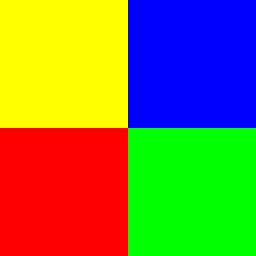

In [4]:
from PIL import Image
import numpy as np

w, h = 256, 256
data = np.zeros((h, w, 3), dtype=np.uint8)

# Yellow
for row in range(128):
    for col in range(128):
        data[row,col] = [255,255,0]
        
# Red
for row in range(128):
    for col in range(128):
        data[row+128,col] = [255,0,0]
        
# Green
for row in range(128):
    for col in range(128):
        data[row+128,col+128] = [0,255,0]        
        
# Blue
for row in range(128):
    for col in range(128):
        data[row,col+128] = [0,0,255]                
        

img = Image.fromarray(data, 'RGB')
img

# Transform Images at the pixel level

We can combine the last two programs and modify images.  Here we take the mean color of each pixel and form a grayscale image.

Rows: 682, Cols: 1024


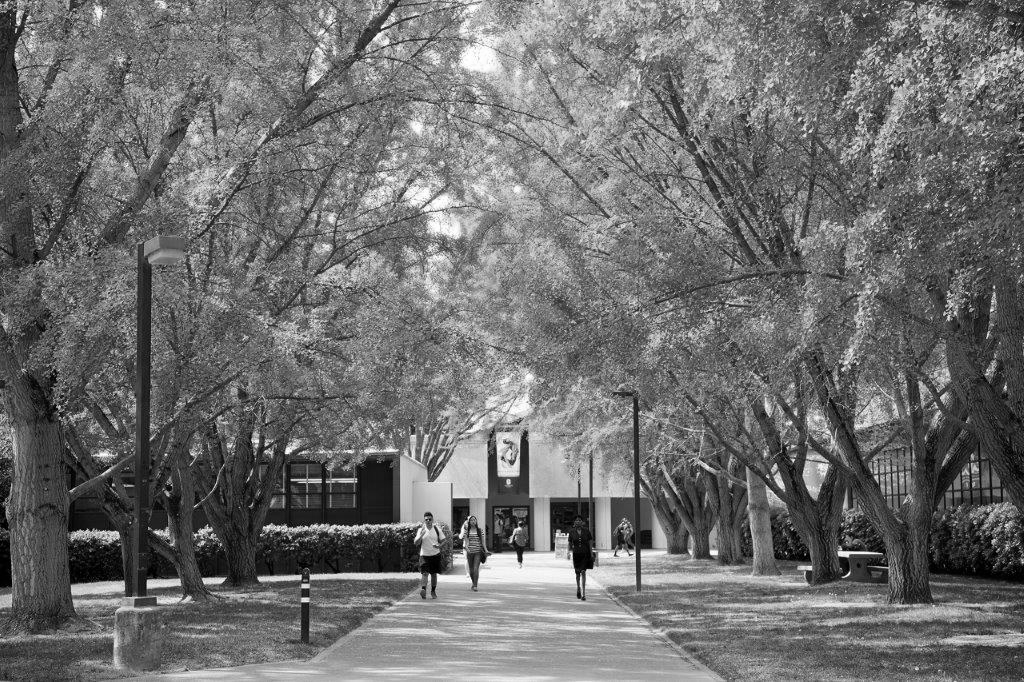

In [5]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

%matplotlib inline

url = "https://www.csus.edu/news/files/1_Campus_Spring_Flowers_Students_FB_20150330_0011.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

img_array = np.asarray(img)
rows = img_array.shape[0]
cols = img_array.shape[1]

print("Rows: {}, Cols: {}".format(rows,cols))

# Create new image
img2_array = np.zeros((rows, cols, 3), dtype=np.uint8)
for row in range(rows):
    for col in range(cols):
        t = np.mean(img_array[row,col])
        img2_array[row,col] = [t,t,t]

img2 = Image.fromarray(img2_array, 'RGB')
img2        
        

## Demo about using auto encoders to handle noise

### Adding Noise to an Image

Auto encoders can handle noise.  First it is important to see how to add noise to an image.  There are many ways to add such noise.  The following code adds random black squares to the image to produce noise.

Rows: 682, Cols: 1024
(682, 1024, 3)


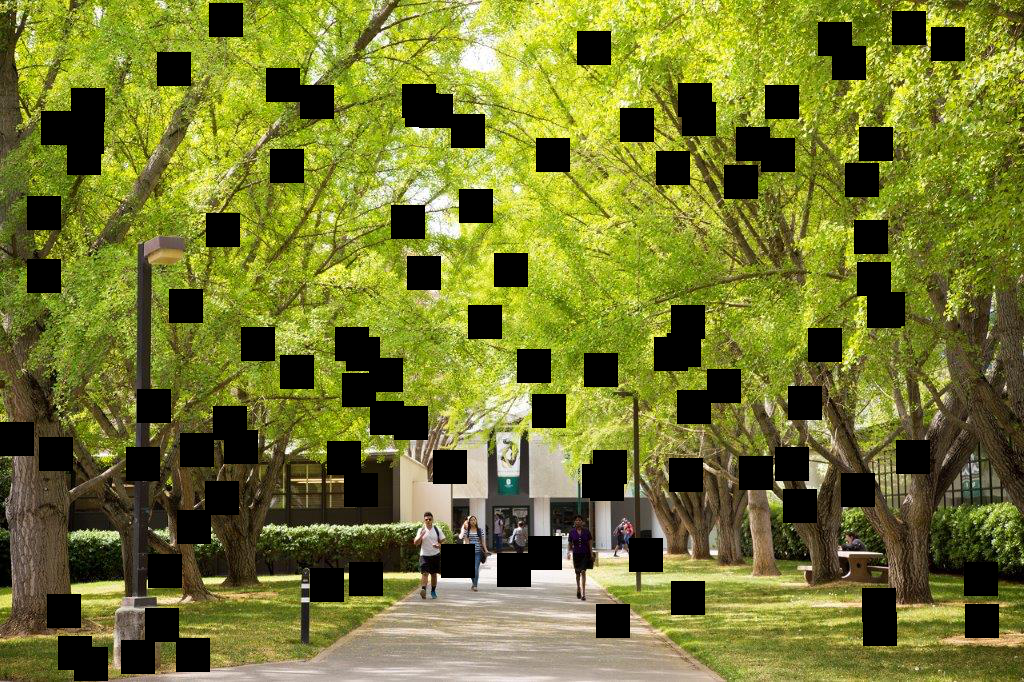

In [6]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

%matplotlib inline


def add_noise(a):
    a2 = a.copy()
    rows = a2.shape[0]
    cols = a2.shape[1]
    s = int(min(rows,cols)/20)  # size of spot is 1/20 of smallest dimension
    
    for i in range(100):
        x = np.random.randint(cols-s)
        y = np.random.randint(rows-s)
        a2[y:(y+s),x:(x+s)] = 0
        
    return a2

url = "https://www.csus.edu/news/files/1_Campus_Spring_Flowers_Students_FB_20150330_0011.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

img_array = np.asarray(img)
rows = img_array.shape[0]
cols = img_array.shape[1]

print("Rows: {}, Cols: {}".format(rows,cols))

# Create new image by adding noise
img_array_noise = add_noise(img_array)

# make sure it is in uint8
img_array_noise= img_array_noise.astype(np.uint8)

print(img_array_noise.shape)

img2 = Image.fromarray(img_array_noise, 'RGB')
img2        

## Denoising Autoencoder

A denoising auto encoder is designed to remove noise from input signals.  

To do this ***the $y$ becomes each image while the $x$ becomes a version of $y$ with noise added.*** 


* Downsampling images using resize() for code efficiency.

https://pillow.readthedocs.io/en/3.1.x/reference/Image.html

* The following code reads a sequence of images and resize them to the same size using ***img.resize()***.  Image.LANCZOS is one of the high-quality downsampling filters you can use with resize(). 

***We create 10 noisy versions of each image.***   The network is trained to convert noisy data ($x$) to the origional input ($y$).

https://www.planetware.com/photos-large/USCA/california-san-francisco-golden-gate-bridge.jpg


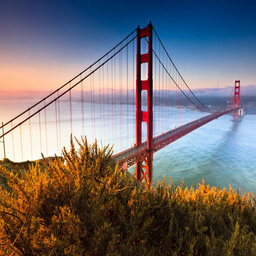

https://upload.wikimedia.org/wikipedia/commons/8/87/Golden_Gate_Bridge_Aerial.jpg


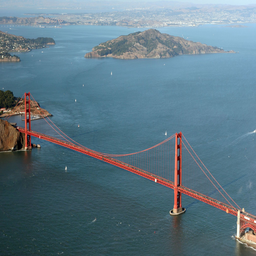

https://www.travelbook.de/data/uploads/2017/09/gettyimages-585577624_1504953116-1040x690.jpg


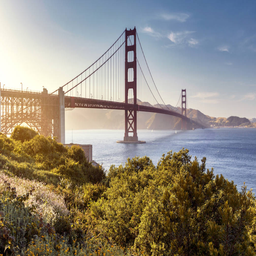

https://avatars.mds.yandex.net/get-pdb/27625/ea43da96-acce-4910-860b-27f8b3612dd9/orig


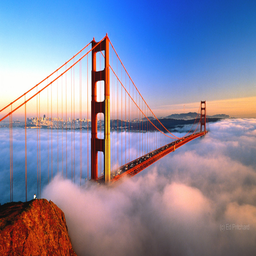

https://www.visittheusa.com/sites/default/files/styles/hero_m_1300x700/public/images/hero_media_image/2017-05/23b0b0b9caaa07ee409b693da9bf9003.jpeg?itok=QUmOkiy_


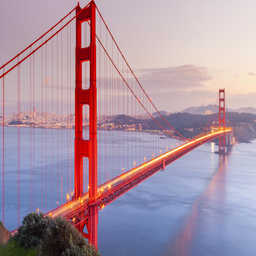

(50, 196608)
(50, 196608)


In [8]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML


images = [
    "https://www.planetware.com/photos-large/USCA/california-san-francisco-golden-gate-bridge.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/8/87/Golden_Gate_Bridge_Aerial.jpg",
    "https://www.travelbook.de/data/uploads/2017/09/gettyimages-585577624_1504953116-1040x690.jpg",
    "https://avatars.mds.yandex.net/get-pdb/27625/ea43da96-acce-4910-860b-27f8b3612dd9/orig",
    "https://www.visittheusa.com/sites/default/files/styles/hero_m_1300x700/public/images/hero_media_image/2017-05/23b0b0b9caaa07ee409b693da9bf9003.jpeg?itok=QUmOkiy_"      
]

    
x = []    
y = []
loaded_images = []
    
for url in images:
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.load()
    img = img.resize((256,256), Image.LANCZOS)
    
    loaded_images.append(img)
    print(url)
    display(img)
    for i in range(10):
        img_array = np.asarray(img)
        img_array_noise = add_noise(img_array)
        
        img_array = img_array.flatten()
        img_array = img_array.astype(np.float32)
        img_array = (img_array-256)/256
        
        img_array_noise = img_array_noise.flatten()
        img_array_noise = img_array_noise.astype(np.float32)
        img_array_noise = (img_array_noise-256)/256
        
        x.append(img_array_noise)
        y.append(img_array)
    
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)


### Why (50, 196608)? 

In [11]:
%matplotlib inline
from PIL import Image, ImageFile
import requests
from io import BytesIO
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display, HTML 


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Fit regression DNN model.
print("Creating/Training neural network")
model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(x.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=1,epochs=200)

print("Neural network trained")


Creating/Training neural network
Epoch 1/200
50/50 [==============================] - 2s 43ms/sample - loss: 0.2797
Epoch 2/200
50/50 [==============================] - ETA: 0s - loss: 0.362 - 0s 8ms/sample - loss: 0.2690
Epoch 3/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.1177
Epoch 4/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0682
Epoch 5/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0550
Epoch 6/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0428
Epoch 7/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0419
Epoch 8/200
50/50 [==============================] - 0s 9ms/sample - loss: 0.0405
Epoch 9/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0386
Epoch 10/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0364
Epoch 11/200
50/50 [==============================] - 0s 9ms/sample - loss: 0.0360
Epoch 12/200
50/50 [==================

50/50 [==============================] - 0s 8ms/sample - loss: 9.8063e-07
Epoch 190/200
50/50 [==============================] - 0s 8ms/sample - loss: 9.1018e-07
Epoch 191/200
50/50 [==============================] - 0s 8ms/sample - loss: 9.0401e-07
Epoch 192/200
50/50 [==============================] - 0s 8ms/sample - loss: 1.0289e-06
Epoch 193/200
50/50 [==============================] - 0s 8ms/sample - loss: 9.8815e-07
Epoch 194/200
50/50 [==============================] - 0s 8ms/sample - loss: 9.4954e-07
Epoch 195/200
50/50 [==============================] - 0s 8ms/sample - loss: 8.3764e-07
Epoch 196/200
50/50 [==============================] - 0s 8ms/sample - loss: 8.1650e-07
Epoch 197/200
50/50 [==============================] - 0s 8ms/sample - loss: 7.3275e-07
Epoch 198/200
50/50 [==============================] - 0s 8ms/sample - loss: 6.8749e-07
Epoch 199/200
50/50 [==============================] - 0s 8ms/sample - loss: 6.7253e-07
Epoch 200/200
50/50 [=========================

*** Trial 1
Before auto encoder (with noise):


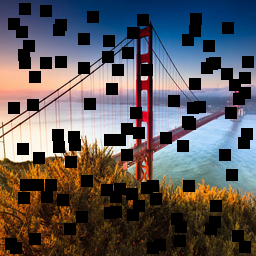

After auto encoder noise removal


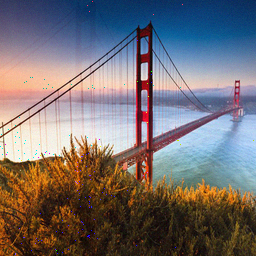

*** Trial 2
Before auto encoder (with noise):


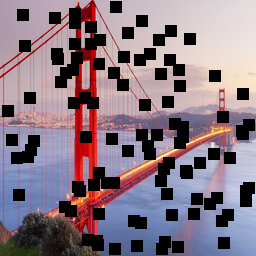

After auto encoder noise removal


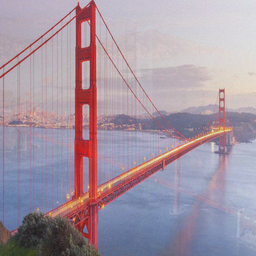

*** Trial 3
Before auto encoder (with noise):


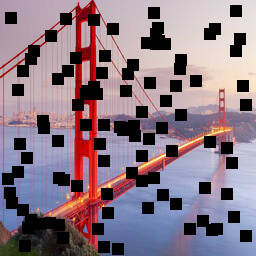

After auto encoder noise removal


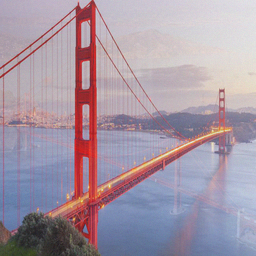

*** Trial 4
Before auto encoder (with noise):


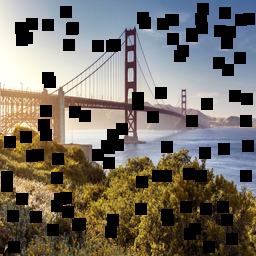

After auto encoder noise removal


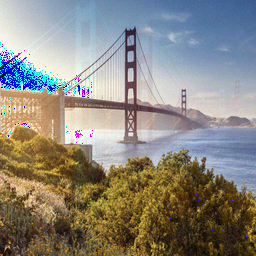

*** Trial 5
Before auto encoder (with noise):


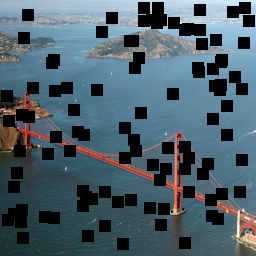

After auto encoder noise removal


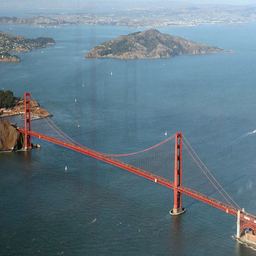

*** Trial 6
Before auto encoder (with noise):


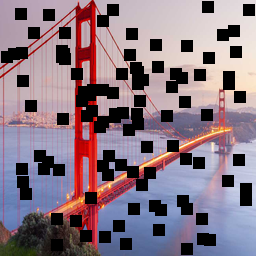

After auto encoder noise removal


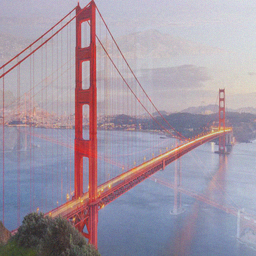

*** Trial 7
Before auto encoder (with noise):


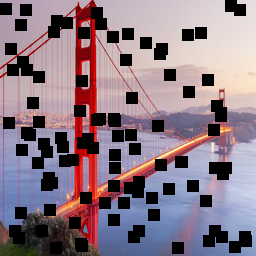

After auto encoder noise removal


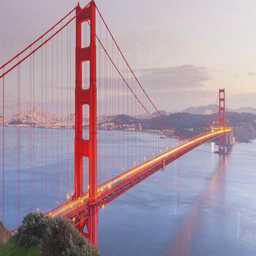

*** Trial 8
Before auto encoder (with noise):


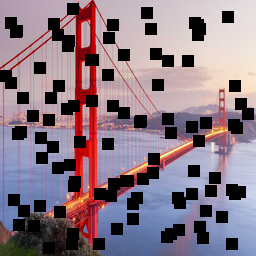

After auto encoder noise removal


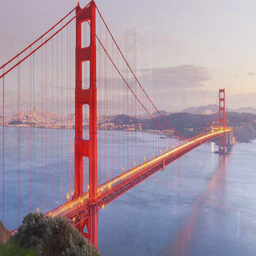

*** Trial 9
Before auto encoder (with noise):


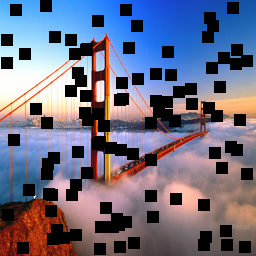

After auto encoder noise removal


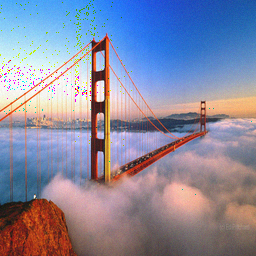

*** Trial 10
Before auto encoder (with noise):


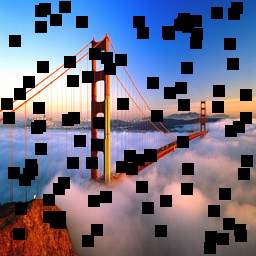

After auto encoder noise removal


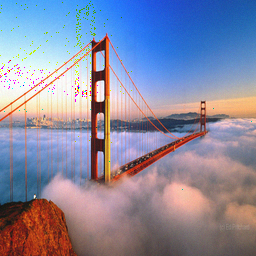

In [12]:
for z in range(10):
    print("*** Trial {}".format(z+1))
    
    # Choose random image
    i = np.random.randint(len(loaded_images))
    img = loaded_images[i]
    img_array = np.asarray(img)
    cols, rows = img.size

    # Add noise
    img_array_noise = add_noise(img_array)    

    #Display noisy image
    img2 = img_array_noise.astype(np.uint8)
    img2 = Image.fromarray(img2, 'RGB')
    print("Before auto encoder (with noise):")
    display(img2)

    # Send noisy image to auto encoder
    img_array_noise = img_array_noise.flatten()
    img_array_noise = img_array_noise.astype(np.float32)
    img_array_noise = (img_array_noise-256)/256
    img_array_noise = np.array([img_array_noise])
    pred = model.predict(img_array_noise)[0]

    # Display neural result
    img_array2 = pred.reshape(rows,cols,3)
    img_array2 = (img_array2*256)+256
    img_array2 = img_array2.astype(np.uint8)
    img2 = Image.fromarray(img_array2, 'RGB')
    print("After auto encoder noise removal")
    display(img2)